In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', np.ComplexWarning)

## 1)
To shift a continious function, we can convolve it with a translated delta function $\delta(x - s)$. For an array, we convolve it with an array of $\delta_{i,s}$, where s is the shift and $i = 0,...,N-1$. 

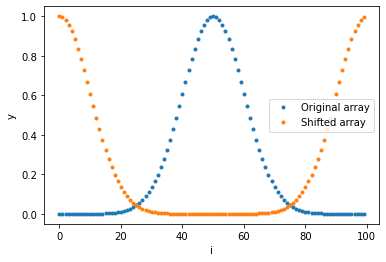

In [2]:
def shift(y, s):
    N = len(y)
    s = s%N # the shift is periodic 
    yft = np.fft.fft(y)
    # we can construct the array explicitly:
    delta = np.zeros(len(y))   
    delta[s] = 1
    shifted_ft = yft*np.fft.fft(delta) # to convolve, multiply in Fourier space
    
    # or, instead, just use the known FT of the translated delta function:
#     k = np.fft.fftfreq(N, d = 1./N)
#     j = np.complex(0,1)
#     phase_shift = np.exp(-2.*np.pi*j*k*s/N)
#     shifted_ft = yft*phase_shift

    shifted_y = np.fft.ifft(shifted_ft)
    return shifted_y

x = np.arange(-5,5, 0.1)
sigma = 1.
gauss = np.exp(-x**2/2./sigma**2)
gauss_shifted = shift(gauss, int(len(gauss)/2))
plt.plot(gauss, '.', label = 'Original array')
plt.plot(gauss_shifted, '.', label = 'Shifted array')
plt.xlabel('i'), plt.ylabel('y'); plt.legend()
plt.show()

## 2)

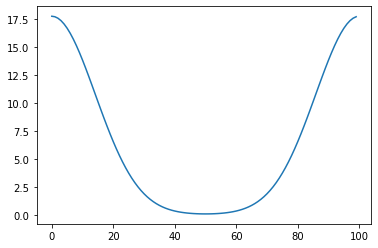

In [3]:
def corr(f, g):
    return np.fft.ifft( np.fft.fft(f) * np.conj(np.fft.fft(g)) )

plt.plot(corr(gauss, gauss)); plt.show()

## 3)

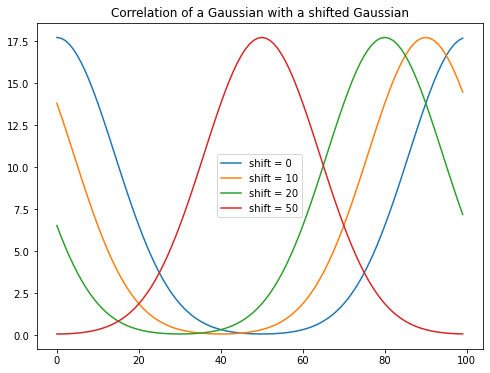

In [4]:
def shifted_corr(y, s):
    return corr(y, shift(y, s))

plt.figure(figsize = (8,6))
for s in (0, 10, 20, 50):
    plt.plot(shifted_corr(gauss, s), label = 'shift = '+ str(s))
plt.title('Correlation of a Gaussian with a shifted Gaussian')
plt.legend(); plt.show()

The results are not surprising. The correlation is a function of the relative displacement and has a maximum where the 2 Gaussians are at the same position. So shifting one of the Gaussians just shifts the correlation function. 

## 4)
To avoid wrapping around, perform zero padding of the input arrays.

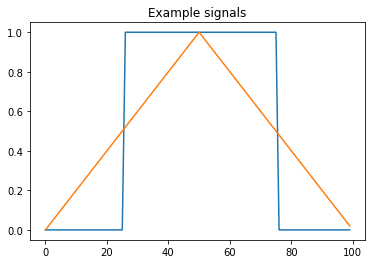

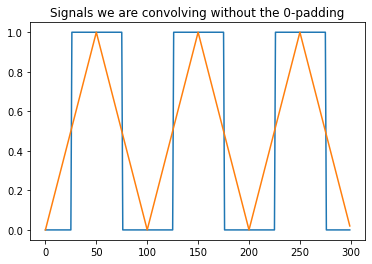

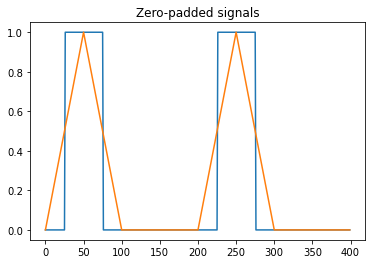

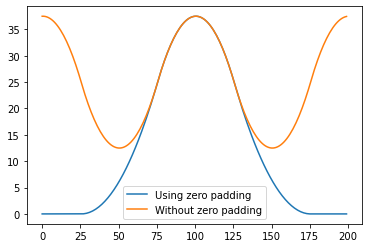

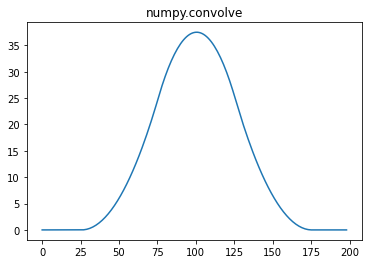

In [5]:
def convolve(f, g):
    f2 = np.pad(f,[0,len(f)])
    g2 = np.pad(g,[0,len(g)])
    ft_f = np.fft.fft(f2)
    ft_g = np.fft.fft(g2)
    return np.fft.ifft(ft_f*ft_g)

# for an example, take a triangular signal and a rectangular one
N = 100
x = np.arange(N)
y1 = np.zeros(N)
y1[26:76] = 1.
y2 = np.zeros(N)
y2[:51] = 0.02*np.arange(51)
y2[50:] = 1. - 0.02*np.arange(50)
plt.plot(y1); plt.plot(y2)
plt.title('Example signals')
plt.show()

plt.plot(np.hstack([y1, y1, y1]))
plt.plot(np.hstack([y2, y2, y2]))
plt.title('Signals we are convolving without the 0-padding')          
plt.show()
          
plt.plot(np.hstack([np.pad(y1, [0, len(y1)]), np.pad(y1, [0, len(y1)])]))
plt.plot(np.hstack([np.pad(y2, [0, len(y2)]), np.pad(y2, [0, len(y2)])]))
plt.title('Zero-padded signals')
plt.show()
          
plt.plot(convolve(y1, y2), label = 'Using zero padding')
simple_conv = np.fft.ifft(np.fft.fft(y1)*np.fft.fft(y2))
plt.plot(np.hstack([simple_conv, simple_conv]), label = 'Without zero padding')
plt.legend(); plt.show()
# we can check how numpy does
plt.plot(np.convolve(y1, y2)); plt.title('numpy.convolve'); plt.show()

## 5)
Please find the proofs in the pdf document.


### c)

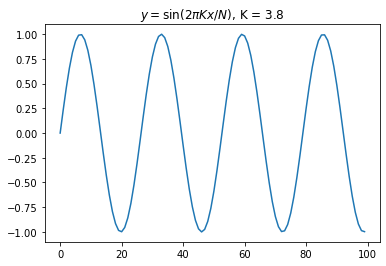

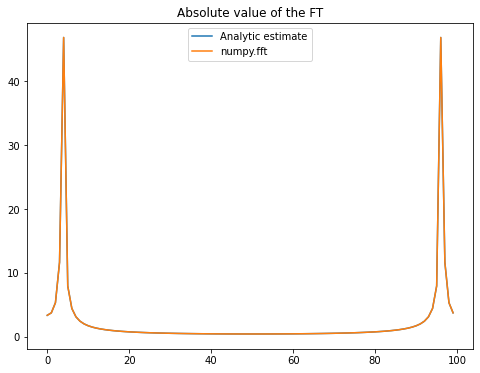

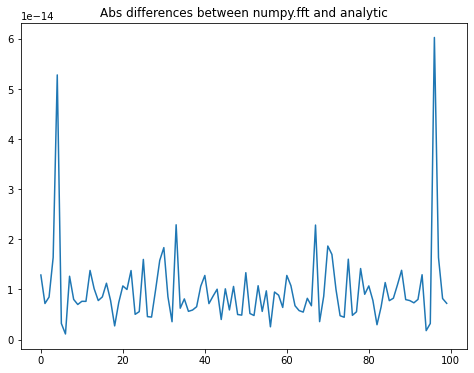

The standard deviation is 1.2035826212758298e-14


In [6]:
N = 100
x = np.arange(N)
K = 3.8  
y = np.sin(2*np.pi*x*K/N) # the non-integer sine wave
plt.plot(y)
plt.title('$y = \sin(2\pi Kx/N)$, K = 3.8')
plt.show()

def sum(k, N):  # a function that calculates the sum from 5a
    j = np.complex(0,1)
    phase = 2.*np.pi*j*k
    return (1 - np.exp(-phase) )/(1. - np.exp(-phase/N))

k = np.fft.fftfreq(N, d = 1./N)
j = np.complex(0,1)
plt.figure(figsize = (8,6))
ft_analytic = 1/2./j*( sum(k - K, N) - sum(k + K, N)) 
sin_ft = np.fft.fft(y)

plt.plot(np.abs(ft_analytic), label = 'Analytic estimate')
plt.plot(np.abs(sin_ft), label = 'numpy.fft')
plt.title('Absolute value of the FT'); plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(np.abs(ft_analytic - sin_ft))
plt.title('Abs differences between numpy.fft and analytic')
plt.show()
print('The standard deviation is', np.std(ft_analytic - sin_ft))

### d)

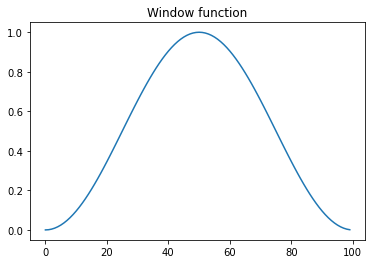

In [7]:
w = 0.5 - 0.5*np.cos(2*np.pi*x/N)
plt.plot(w); plt.title('Window function')
plt.show()

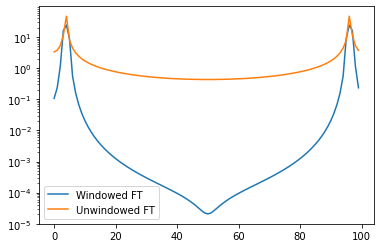

In [8]:
wy = w*y
# make a semilog plot to compare the degrees of the leakage
plt.semilogy(np.abs(np.fft.fft(wy)), label = 'Windowed FT')
plt.semilogy(np.abs(sin_ft), label = 'Unwindowed FT')
plt.legend(); plt.show()

### e)
Check the analytic result for the Fourier transform of the window function numerically:

In [9]:
print([float('%.5f'% wk) for wk in np.fft.fft(w)[:5]/N]) # divided by N !
print('...')
print([float('%.5f'% wk) for wk in np.fft.fft(w)[-5:]/N])

[0.5, -0.25, -0.0, -0.0, 0.0]
...
[0.0, 0.0, -0.0, -0.0, -0.25]


Check that the combination of points of the unwindowed FT gives the same result as the windowed FT:

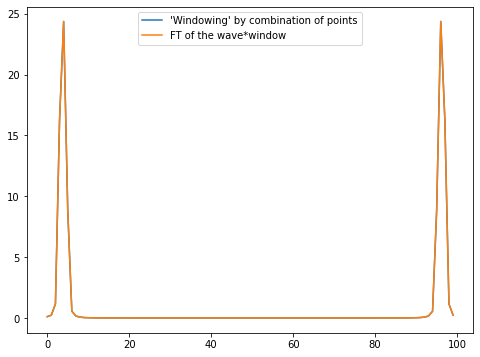

In [10]:
def windowed(ft):
    N = len(ft)
    wft = [ft[i]*1/2 - shift(ft, -1)[i]*1/4 - shift(ft, 1)[i]*1/4 for i in range(N)]
    return np.array(wft)

plt.figure(figsize = (8,6))
plt.plot(np.abs(windowed(sin_ft)), label = '\'Windowing\' by combination of points')
plt.plot(np.abs(np.fft.fft(wy)), label = 'FT of the wave*window')
plt.legend()
plt.show()